In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/scripts')

In [ ]:
!pip install -r /content/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 KB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 110.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 KB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB

In [ ]:
import wandb
wandb.init(project="text-to-face", name="n-dfgan")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.13.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
import os
import random
import functools

import pandas as pd
import numpy as np
from numpy import sqrt, prod
import matplotlib.pyplot as plt
from collections import OrderedDict
from dataclasses import asdict, dataclass

from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import interpolate
from torch.nn.modules.utils import _pair
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
from preprocess import get_weighted_dataloader, extract_zip
from text_encoder.sentence_encoder import SentenceEncoder

In [ ]:
ZIP_PATH = "/content/drive/MyDrive/scripts/Copy of celeb.zip"
OUTPUT_DIR = "/content/output"
extract_zip(ZIP_PATH, OUTPUT_DIR)

In [ ]:
@dataclass
class Config:
    epochs: int = 16
    batch_size: int = 32
    subset_size: int = 20_000
    dataset_len = 202599

    noise_size: int = 100
    feature_size: int = 64
    image_size: int = 128
    save_epoch: int = 1
    conditional: bool = True

    embedding_dim: int = 768
    reduced_embedding_dim: int = 256

    g_lr: float = 0.0002
    d_lr: float = 0.0002

    uncond_loss: int = 1.0
    colour_loss: int = 0.0
    kl_loss: int = 2.0

    device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
cfg = Config()
cfg_dict = asdict(cfg)
wandb.config.update(cfg_dict)

In [ ]:
sentence_encoder = SentenceEncoder(cfg.device)

  0%|          | 0.00/405M [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

In [ ]:
class ImageTextDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, csv_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.text_df = pd.read_csv(csv_file)
        self.length = len(self.text_df)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.text_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Real Images
        img_name = os.path.join(self.root_dir, self.text_df.iloc[idx, 0])
        image = Image.open(img_name)

        true_text = random.choice(self.text_df.iloc[idx, 1:].values[0].split('\n')).strip()

        if self.transform:
            true_image = self.transform(image)

        # Wrong Images
        wrong_idx = random.randint(0, self.length - 1)
        while wrong_idx == idx:
            # To get a different index incase it is same
            wrong_idx = random.randint(0, self.length - 1)
        wrong_img_name = os.path.join(self.root_dir, self.text_df.iloc[wrong_idx, 0])
        wrong_image = Image.open(wrong_img_name)

        if self.transform:
            wrong_image = self.transform(wrong_image)

        return true_image, true_text, wrong_image

In [ ]:
dataset = ImageTextDataset(
    root_dir='/content/output/img_align_celeba/img_align_celeba',
    csv_file='/content/drive/MyDrive/text_5_descr_celeba.csv',
    transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]),
)

In [ ]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    '/content/list_attr_celeba.csv',
    custom_dataset=dataset,
    subset_size=cfg.subset_size,
    batch_size=cfg.batch_size
)

Length of random indices: 20000
Classes present:  {'Big_Lips', 'Black_Hair', 'Wearing_Necklace', 'Eyeglasses', 'Attractive', 'Smiling', 'Goatee', 'Straight_Hair', 'Big_Nose', 'Young', 'Wearing_Necktie', 'Wearing_Earrings', 'Gray_Hair', 'Male', 'Double_Chin', 'Chubby', 'Rosy_Cheeks', 'Blond_Hair', 'Mouth_Slightly_Open', 'Sideburns', 'Heavy_Makeup', 'Brown_Hair', 'Receding_Hairline', 'Oval_Face', 'Mustache', 'Arched_Eyebrows', 'Wearing_Hat', 'Wavy_Hair', 'Pointy_Nose', '5_o_Clock_Shadow', 'Wearing_Lipstick', 'Pale_Skin', 'Bushy_Eyebrows', 'Bald', 'High_Cheekbones', 'Narrow_Eyes'}
Number of classes:  36
Length of subset dataset: 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using Custom Dataset Loader...


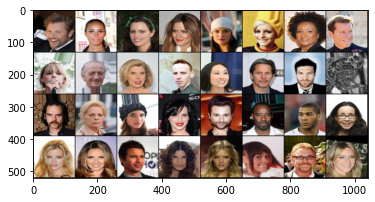

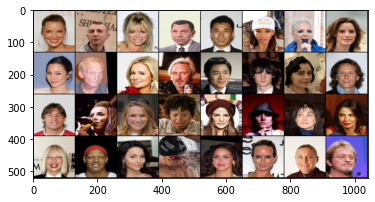

["The gentleman has high cheekbones. He has a 5 o' clock shadow. He has brown and straight hair. He has a slightly open mouth. He is smiling, seems attractive and young.", 'The female has an oval face. She has straight and receding hair. She has arched eyebrows, big lips, a big nose, bushy eyebrows and a slightly open mouth. The female is attractive, young, has heavy makeup and rosy cheeks. She is wearing earrings and lipstick.', 'The lady has high cheekbones and an oval face. She has wavy hair. She has a slightly open mouth. She seems attractive, young, is smiling and has heavy makeup. She is wearing lipstick.', 'The woman has high cheekbones. The lady looks attractive, young, is smiling and has heavy makeup. She is wearing lipstick.', 'The woman is attractive, young and has heavy makeup. She is wearing a hat and lipstick.', 'The female has pretty high cheekbones. She has blond and straight hair. She has big lips and a slightly open mouth. The female looks attractive, young, is smilin

In [ ]:
real_images, labels, wrong_images = next(weighted_dataiter)
show_grid(torchvision.utils.make_grid(real_images, normalize=True))
show_grid(torchvision.utils.make_grid(wrong_images, normalize=True))
print(labels)

In [ ]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [ ]:
class affine(nn.Module):
  def __init__(self, num_features):
    super(affine, self).__init__()
    self.fc_gamma = nn.Sequential(OrderedDict([
            ('linear1',nn.Linear(256, 256)),
            ('relu1',nn.ReLU(inplace=True)),
            ('linear2',nn.Linear(256, num_features)),
            ]))

    self.fc_beta = nn.Sequential(OrderedDict([
            ('linear1',nn.Linear(256, 256)),
            ('relu1',nn.ReLU(inplace=True)),
            ('linear2',nn.Linear(256, num_features)),
            ]))
    self._initialize()

  def _initialize(self):
    nn.init.zeros_(self.fc_gamma.linear2.weight.data)
    nn.init.ones_(self.fc_gamma.linear2.bias.data)
    nn.init.zeros_(self.fc_beta.linear2.weight.data)
    nn.init.zeros_(self.fc_beta.linear2.bias.data)

  def forward(self, x, y=None):
    weight = self.fc_gamma(y)
    bias = self.fc_beta(y)

    if weight.dim() == 1:
        weight = weight.unsqueeze(0)
    if bias.dim() == 1:
        bias = bias.unsqueeze(0)

    size = x.size()
    weight = weight.unsqueeze(-1).unsqueeze(-1).expand(size)
    bias = bias.unsqueeze(-1).unsqueeze(-1).expand(size)
    return weight * x + bias

In [ ]:
class G_Block(nn.Module):
    def __init__(self, in_ch, out_ch):
      super(G_Block, self).__init__()

      self.learnable_sc = in_ch != out_ch
      self.c1 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
      self.c2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1)
      self.affine0 = affine(in_ch)
      self.affine1 = affine(in_ch)
      self.affine2 = affine(out_ch)
      self.affine3 = affine(out_ch)
      self.gamma = nn.Parameter(torch.zeros(1))
      if self.learnable_sc:
          self.c_sc = nn.Conv2d(in_ch,out_ch, 1, stride=1, padding=0)

    def forward(self, x, y=None):
      return self.shortcut(x) + self.gamma * self.residual(x, y)

    def shortcut(self, x):
      if self.learnable_sc:
          x = self.c_sc(x)
      return x

    def residual(self, x, y=None):
      h = self.affine0(x, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.affine1(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.c1(h)

      h = self.affine2(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.affine3(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      return self.c2(h)

In [ ]:
class NetG(nn.Module):
  def __init__(self, ngf = 64, nz = 100):
    super(NetG, self).__init__()
    self.ngf = ngf
    self.nz = nz

    self.fc = nn.Linear(self.nz, self.ngf * 8 * 4 * 4)
    self.reduce_dim = nn.Linear(768, 256)
    self.block0 = G_Block(ngf * 8, ngf * 8)#4x4
    self.block1 = G_Block(ngf * 8, ngf * 8)#4x4
    self.block2 = G_Block(ngf * 8, ngf * 8)#8x8
    self.block3 = G_Block(ngf * 8, ngf * 8)#16x16
    self.block4 = G_Block(ngf * 8, ngf * 4)#32x32
    self.block5 = G_Block(ngf * 4, ngf)#64x64
    # self.block6 = G_Block(ngf * 2, ngf * 1)#128x128

    self.conv_img = nn.Sequential(
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ngf, 3, 3, 1, 1),
            nn.Tanh(),
        )

  def forward(self, x, c):
    out = self.fc(x)
    out = out.view(x.size(0), 8*self.ngf, 4, 4)
    c = self.reduce_dim(c)
    out = self.block0(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block1(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block2(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block3(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block4(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block5(out,c)

    # out = F.interpolate(out, scale_factor=2)
    # out = self.block6(out,c)

    out = self.conv_img(out)

    return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class D_GET_LOGITS(nn.Module):
    def __init__(self, ndf):
      super(D_GET_LOGITS, self).__init__()
      self.df_dim = ndf

      self.reduced_dim = nn.Linear(768, 256)

      self.joint_conv = nn.Sequential(
          nn.Conv2d(ndf * 16+256, ndf * 2, 3, 1, 1, bias=False),
          nn.LeakyReLU(0.2,inplace=True),
          nn.Conv2d(ndf * 2, 1, 2, 1, 0, bias=False),
      )

    def forward(self, out, y):
      y = self.reduced_dim(y)
      y = y.view(-1, 256, 1, 1)
      y = y.repeat(1, 1, 2, 2)
      h_c_code = torch.cat((out, y), 1)
      out = self.joint_conv(h_c_code)
      # print(out.shape)
      return out

In [ ]:
class resD(nn.Module):
    def __init__(self, fin, fout, downsample=True):
      super().__init__()
      self.downsample = downsample
      self.learned_shortcut = (fin != fout)
      self.conv_r = nn.Sequential(
          nn.Conv2d(fin, fout, 4, 2, 1, bias=False),
          nn.LeakyReLU(0.2, inplace=True),

          nn.Conv2d(fout, fout, 3, 1, 1, bias=False),
          nn.LeakyReLU(0.2, inplace=True),
      )

      self.conv_s = nn.Conv2d(fin,fout, 1, stride=1, padding=0)
      self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x, c=None):
      return self.shortcut(x)+self.gamma*self.residual(x)

    def shortcut(self, x):
      if self.learned_shortcut:
          x = self.conv_s(x)
      if self.downsample:
          return F.avg_pool2d(x, 2)
      return x

    def residual(self, x):
      return self.conv_r(x)

In [ ]:
class NetD(nn.Module):
    def __init__(self, ndf):
      super(NetD, self).__init__()

      self.conv_img = nn.Conv2d(3, ndf, 3, 1, 1)#128
      self.block0 = resD(ndf * 1, ndf * 2)#64
      self.block1 = resD(ndf * 2, ndf * 4)#32
      self.block2 = resD(ndf * 4, ndf * 8)#16
      self.block3 = resD(ndf * 8, ndf * 16)#8
      self.block4 = resD(ndf * 16, ndf * 16)#4
      self.block5 = resD(ndf * 16, ndf * 16)#4

      self.COND_DNET = D_GET_LOGITS(ndf)

    def forward(self,x):
      out = self.conv_img(x)
      out = self.block0(out)
      out = self.block1(out)
      out = self.block2(out)
      out = self.block3(out)
      out = self.block4(out)
      out = self.block5(out)
      return out

In [ ]:
netG = NetG(64, 100).to(device)
netD = NetD(64).to(device)

netG.cuda().train()
netD.cuda().train()

NetD(
  (conv_img): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block0): resD(
    (conv_r): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv_s): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (block1): resD(
    (conv_r): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv_s): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (block2): resD(
    (conv_r): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), s

In [ ]:
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0001, betas=(0.0, 0.9))
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0004, betas=(0.0, 0.9))

In [ ]:
plt_images, plt_labels, fake_img = next(weighted_dataiter)
fixed_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
fixed_embeddings.shape

torch.Size([32, 768])

In [ ]:
fixed_noise = torch.randn(size=(len(plt_labels), cfg.noise_size)).cuda()
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():

    netG.eval()
    test_images = netG(fixed_noise, fixed_embeddings)
    netG.train()

    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

  wandb.log({'output': wandb.Image(grid, caption=f'Output for epoch: {epoch}')}, step=epoch)

0it [00:00, ?it/s]

Epoch : 1 / 16


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "




Epoch : 1 | Loss_D : 1.3113305568695068 | Loss_G : 1.285521149635315


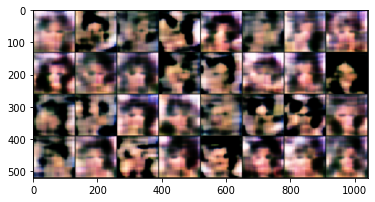

Epoch : 2 / 16


Epoch : 2 | Loss_D : 1.2773327827453613 | Loss_G : 1.572751760482788


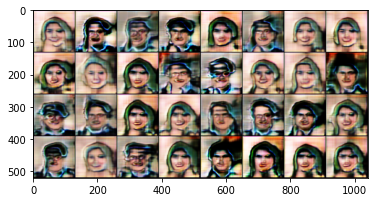

Epoch : 3 / 16


Epoch : 3 | Loss_D : 1.6423512697219849 | Loss_G : 0.9943993091583252


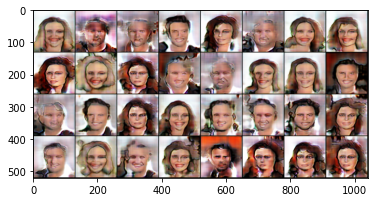

Epoch : 4 / 16


Epoch : 4 | Loss_D : 1.3614130020141602 | Loss_G : 1.197013020515442


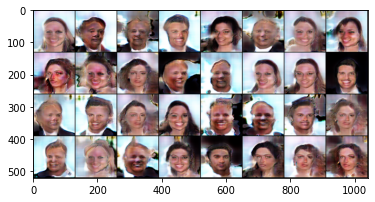

Epoch : 5 / 16


Epoch : 5 | Loss_D : 1.2989743947982788 | Loss_G : 0.3100985884666443


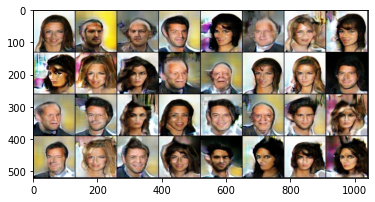

Epoch : 6 / 16


Epoch : 6 | Loss_D : 0.9099507927894592 | Loss_G : 1.4935635328292847


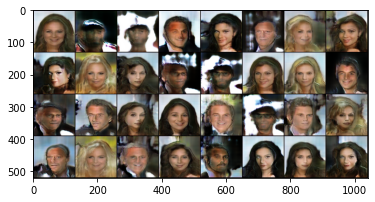

Epoch : 7 / 16


Epoch : 7 | Loss_D : 1.250562310218811 | Loss_G : 1.1557976007461548


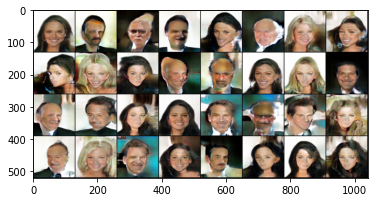

Epoch : 8 / 16


Epoch : 8 | Loss_D : 1.1955058574676514 | Loss_G : 1.4978532791137695


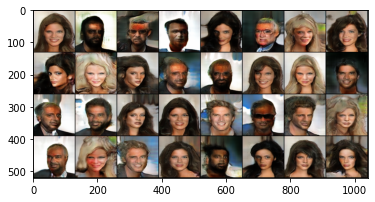

Epoch : 9 / 16


Epoch : 9 | Loss_D : 1.2412199974060059 | Loss_G : -0.07767800986766815


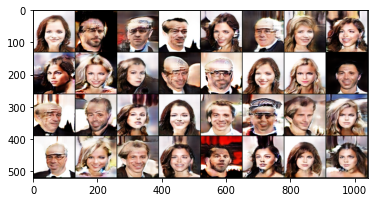

Epoch : 10 / 16


Epoch : 10 | Loss_D : 1.1420239210128784 | Loss_G : 1.4534220695495605


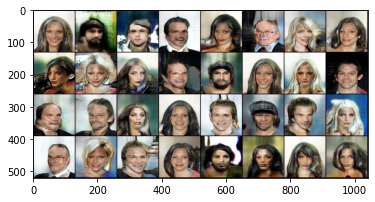

Epoch : 11 / 16


Epoch : 11 | Loss_D : 1.1950361728668213 | Loss_G : -0.5532205700874329


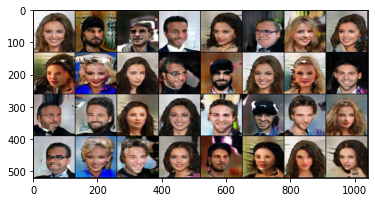

Epoch : 12 / 16


Epoch : 12 | Loss_D : 1.2090704441070557 | Loss_G : -0.038635700941085815


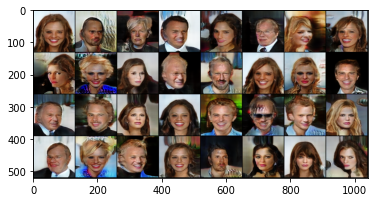

Epoch : 13 / 16


Epoch : 13 | Loss_D : 1.0075958967208862 | Loss_G : 0.6388511657714844


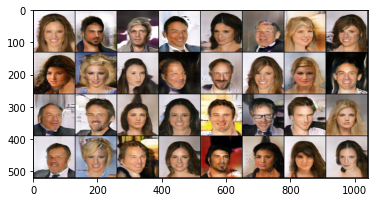

Epoch : 14 / 16


Epoch : 14 | Loss_D : 0.9956591129302979 | Loss_G : 0.6086198091506958


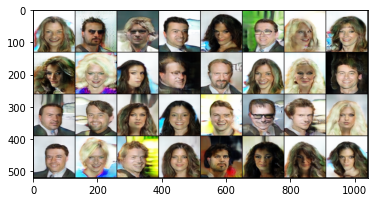

Epoch : 15 / 16


Epoch : 15 | Loss_D : 1.1837847232818604 | Loss_G : 1.408081293106079


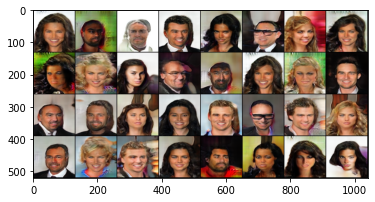

Epoch : 16 / 16


Epoch : 16 | Loss_D : 1.0694503784179688 | Loss_G : 1.8789753913879395


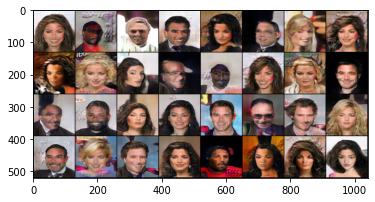

True

In [ ]:
pbar = tqdm()

wandb.watch(netG)
wandb.watch(netD)

for epoch in range(cfg.epochs):
  print(f'Epoch : {epoch + 1} / {cfg.epochs}')
  pbar.reset(total = len(weighted_dataloader))

  discriminator_loss = []
  generator_loss = []

  for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
    current_batch_size = real_images.size()[0]

    #convert to CUDA
    real_images = real_images.cuda()
    text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)
    wrong_images = wrong_images.cuda()

    real_validity = torch.ones(current_batch_size, 1).cuda()
    fake_validity = torch.zeros(current_batch_size, 1).cuda()

    temp_tensor = (torch.ones(current_batch_size, 1).cuda()) * (-0.1)
    smoothed_real_labels = torch.add(real_validity, temp_tensor)

    real_features = netD(real_images)
    output = netD.COND_DNET(real_features,text_embeddings)
    errD_real = torch.nn.ReLU()(1.0 - output).mean()

    output = netD.COND_DNET(real_features[:(current_batch_size - 1)], text_embeddings[1:current_batch_size])
    errD_mismatch = torch.nn.ReLU()(1.0 + output).mean()

    # synthesize fake images
    noise = torch.randn(current_batch_size, 100)
    noise=noise.to(device)
    fake = netG(noise,text_embeddings)

    # G does not need update with D
    fake_features = netD(fake.detach())

    errD_fake = netD.COND_DNET(fake_features,text_embeddings)
    errD_fake = torch.nn.ReLU()(1.0 + errD_fake).mean()

    errD = errD_real + (errD_fake + errD_mismatch)/2.0
    optimizerD.zero_grad()
    optimizerG.zero_grad()
    errD.backward()
    optimizerD.step()

    #MA-GP
    interpolated = (real_images.data).requires_grad_()
    sent_inter = (text_embeddings.data).requires_grad_()
    features = netD(interpolated)
    out = netD.COND_DNET(features,sent_inter)
    grads = torch.autograd.grad(outputs=out,
                            inputs=(interpolated,sent_inter),
                            grad_outputs=torch.ones(out.size()).cuda(),
                            retain_graph=True,
                            create_graph=True,
                            only_inputs=True)
    grad0 = grads[0].view(grads[0].size(0), -1)
    grad1 = grads[1].view(grads[1].size(0), -1)
    grad = torch.cat((grad0,grad1),dim=1)
    grad_l2norm = torch.sqrt(torch.sum(grad ** 2, dim=1))
    d_loss_gp = torch.mean((grad_l2norm) ** 6)
    d_loss = 2.0 * d_loss_gp
    optimizerD.zero_grad()
    optimizerG.zero_grad()
    d_loss.backward()
    optimizerD.step()

    # update G
    features = netD(fake)
    output = netD.COND_DNET(features,text_embeddings)
    errG = - output.mean()
    optimizerG.zero_grad()
    optimizerD.zero_grad()
    errG.backward()
    optimizerG.step()
    # print(f'Loss_D : {errD.item()}')

    pbar.update()

  print('\n')
  print(f'Epoch : {epoch + 1} | Loss_D : {errD.item()} | Loss_G : {errG.item()}')

  wandb.log({"generator loss" : errG.item(), "discriminator loss" : errD.item()}, step=epoch+1)

  if (epoch + 1) % 1 == 0:
    plot_output(epoch + 1)

pbar.refresh()


In [ ]:
import torch


# Save the generator
torch.save(netG.state_dict(), "/content/drive/MyDrive/netG.pt")

# Save the discriminator
torch.save(netD.state_dict(), "/content/drive/MyDrive/netD.pt")

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['''
The woman has high cheekbones.
She has straight hair which is
brown in colour. She has arched
eyebrows and a slightly open
mouth. The smiling, young attractive woman has heavy makeup. She
is wearing lipstick.
'''])

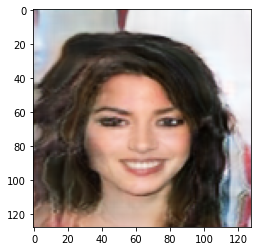

In [ ]:
netG.eval()
test_image = netG(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['''
The lady has high cheekbones and an oval face. She has wavy hair She has big lips and a slightly open mouth The female is smiling seems attractive, young and has heavy makeup She is wearing earrings, lipstick and a necklace
'''])

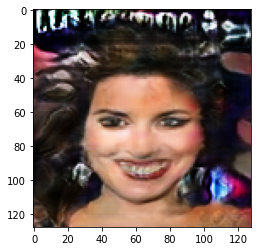

In [ ]:
netG.eval()
test_image = netG(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))